# Kaggle competition : Housing Price prediction 

<b>Objective </b>: Predict house price 
    
<b>Problem type</b> : Regression 

<b>Data </b>: described in Data/data_description.txt 
    
<b>Modelisation </b>: 
    
    

## Import libraries 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 

## Experimentation 1 : Testing different models with a selection of features (only non null values)

We are choosing some numerical features to train a first model 



In [3]:
from sklearn.model_selection import train_test_split

# Get input data 
X_full = pd.read_csv('Data/train.csv', sep=',', index_col='Id')
X_full_test = pd.read_csv('Data/test.csv', sep=',', index_col='Id')

# Predictors
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
X = X_full[features].copy()
X_test = X_full_test[features].copy()

# Target
y = X_full.SalePrice


X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [119]:
from sklearn.metrics import mean_absolute_error

# Getting mae performance for testing different models
def get_mae(X_train, y_train, X_val, y_val, model):
    '''Function that computes the mae perfomance for a given model given in input
    ----------
    Returns : 
        error (float) : MAE value given the input model and X, y datasets
    -----------
    Agurments :
        X_train, X_test (dataframes) : Input dataframes for test and train sets
        y_train, y_test (Series)     : Series of labels for test and train sets
    
    '''
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    error = mean_absolute_error(predictions, y_val)
    return error


In [120]:
# Testing different models 

from sklearn.ensemble import RandomForestRegressor

# Define the models
model_1 = RandomForestRegressor(n_estimators=50, random_state=0)
model_2 = RandomForestRegressor(n_estimators=100, random_state=0)
model_3 = RandomForestRegressor(n_estimators=100, criterion='mae', random_state=0)
model_4 = RandomForestRegressor(n_estimators=200, min_samples_split=20, random_state=0)
model_5 = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=0)

models = [model_1, model_2, model_3, model_4, model_5]

In [121]:
for i, model in enumerate(models) :
    score = get_mae(X_train, y_train, X_val, y_val, model=model)
    print('Score model_{} : '.format(i+1), score)

Score model_1 :  24015.492818003917
Score model_2 :  23740.979228636657
Score model_3 :  23528.78421232877
Score model_4 :  23996.676789668687
Score model_5 :  23706.672864217904


The model 3 is the most performant in this first try ! This is the one we'll use ! 

In [123]:
## Submitting results for model 3 and selected features 

# Fit the model to the training data
model_3.fit(X_train, y_train)

# Generate test predictions
preds_test = model_3.predict(X_test)

# Save predictions in format used for competition scoring
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)


## Experimentation 2 : Handling missing data 

### Import data 

In [255]:
from sklearn.model_selection import train_test_split

# Get input data 
X_full = pd.read_csv('Data/train.csv', sep=',', index_col='Id')
X_full_test = pd.read_csv('Data/test.csv', sep=',', index_col='Id')

# Remove rows with missing target
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)

# Separate target from predictors
y = X_full.SalePrice
X = X_full.drop('SalePrice', axis=1, inplace=True)

# To keep things simple, we'll use only numerical predictors
X = X_full.select_dtypes(exclude=['object'])
X_test = X_full_test.select_dtypes(exclude=['object'])


X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [257]:
len(X_test.columns) == len(X_train.columns)

True

###  Missing data  exploration

In [133]:
# Handling missing data 

# Number of lines 
print('total size', len(X_full))

# Columns with missing values 
cols_to_drop = [col for col in X_train.columns if X_train[col].isnull().sum() > 0 ]
print('Columns with missing values : ', cols_missing_values)


# Number of missing values 
S_missing_values = X_full.isnull().sum()
print('Missing values by columns', S_missing_values[S_missing_values > 0], 'Total number of missing entries', S_missing_values.sum() )

total size 1460
Columns with missing values :  ['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
Missing values by columns LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64 Total number of missing entries 6965


### Strategy 1 : Removing columns with missing data 



In [126]:
# Dropping columns with missing values 

reduced_X_train = X_train.drop(cols_to_drop, axis=1)
reduced_X_val = X_val.drop(cols_to_drop, axis=1)


print(get_mae(X_train=reduced_X_train, y_train=y_train,
                    X_val=reduced_X_val, y_val=y_val, model=model_3))

17895.090633561642


### Strategy 2 : Imputing missing data 

In [139]:


from sklearn.impute import SimpleImputer

my_imputer = SimpleImputer(strategy='median')
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_val = pd.DataFrame(my_imputer.transform(X_val))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_val.columns = X_val.columns

print(get_mae(X_train=imputed_X_train, y_train=y_train,
                    X_val=imputed_X_val, y_val=y_val, model=model_3))

18093.391643835614


The two strategies have almost the same results ! We choose to apply the imputation method. We see that the score have been increased ! 

## Submitting results

In [140]:
## Preparing submission

# Preparing data : handling missing data 

# Fit the model to the training data
model_3.fit(imputed_X_train, y_train)

# Imputing on missing values for X_test
imputed_X_test = pd.DataFrame(my_imputer.fit_transform(X_test))
imputed_X_test.columns = X_test.columns

# Generate test predictions
preds_test = model_3.predict(imputed_X_test)

# Save predictions in format used for competition scoring
output = pd.DataFrame({'Id': imputed_X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)

In [58]:
assert (len(output) == 1459 )

## Experimentation 3 : Handling categorical variables 

### Import data : keeping categorical features

In [337]:
from sklearn.model_selection import train_test_split

# Get input data 
X_full = pd.read_csv('Data/train.csv', sep=',', index_col='Id')
X_test = pd.read_csv('Data/test.csv', sep=',', index_col='Id')

# Remove rows with missing target
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)

# Separate target from predictors
y = X_full.SalePrice
X = X_full.drop('SalePrice', axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8,
                                                 test_size=0.2, random_state=0)

In [291]:
# Removing columns that are in train set but not into test set 

print(len(X_train.columns) == len(X_test.columns)) # To test every time 


True


In [293]:
print(len(X_train.columns) == len(X_val.columns))

True


### Exploring categorical features 


In [294]:
# Categorical columns
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']

# Cardinality of categorical features 
categorical_cardinality = list(map(lambda col : X_train[col].nunique(),categorical_cols))
d = dict(zip(categorical_cols, categorical_cardinality))
sorted(d.items(), key=lambda x : x[1])

[('Street', 2),
 ('Alley', 2),
 ('Utilities', 2),
 ('CentralAir', 2),
 ('LandSlope', 3),
 ('GarageFinish', 3),
 ('PavedDrive', 3),
 ('PoolQC', 3),
 ('MiscFeature', 3),
 ('LotShape', 4),
 ('LandContour', 4),
 ('MasVnrType', 4),
 ('ExterQual', 4),
 ('BsmtQual', 4),
 ('BsmtCond', 4),
 ('BsmtExposure', 4),
 ('KitchenQual', 4),
 ('Fence', 4),
 ('MSZoning', 5),
 ('LotConfig', 5),
 ('BldgType', 5),
 ('ExterCond', 5),
 ('HeatingQC', 5),
 ('Electrical', 5),
 ('FireplaceQu', 5),
 ('GarageQual', 5),
 ('GarageCond', 5),
 ('Condition2', 6),
 ('RoofStyle', 6),
 ('Foundation', 6),
 ('BsmtFinType1', 6),
 ('BsmtFinType2', 6),
 ('Heating', 6),
 ('Functional', 6),
 ('GarageType', 6),
 ('SaleCondition', 6),
 ('RoofMatl', 7),
 ('HouseStyle', 8),
 ('Condition1', 9),
 ('SaleType', 9),
 ('Exterior1st', 15),
 ('Exterior2nd', 16),
 ('Neighborhood', 25)]

### Strategy 1 : Dropping categorical features + Imputation on null values 

In [179]:
# Dropping categorical feaures 
reduced_X_train = X_train.select_dtypes(exclude=['object'])
reduced_X_val = X_val.select_dtypes(exclude=['object'])

# Imputing on missing values 
my_imputer = SimpleImputer(strategy='median')
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(reduced_X_train))
imputed_X_val = pd.DataFrame(my_imputer.transform(reduced_X_val))

# Imputation removed column names; put them back
imputed_X_train.columns = reduced_X_train.columns
imputed_X_val.columns = reduced_X_val.columns

# Getting MAE performance 
print(get_mae(X_train=imputed_X_train, y_train=y_train,
                    X_val=imputed_X_val, y_val=y_val, model=model_3))

18093.391643835614


### Strategy 2 : Label encoding + imputation

In [210]:
from sklearn.preprocessing import LabelEncoder

# Categorical columns
obj_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']

# Dropping categorical values available into X_val but unavailable into X_train
good_label_cols = [col for col in X_train.columns if set(X_train[col]) == set(X_val[col])]
bad_label_cols = list(set(obj_cols) - set(good_label_cols))

X_train = X_train.drop(bad_label_cols, axis=1)
X_val = X_val.drop(bad_label_cols, axis=1)

# Dropping categorical columns with empty values 
empty_label_cols = [col for col in good_label_cols if X_train[col].isnull().sum() > 0]
label_X_train = X_train.drop(empty_label_cols, axis=1)
label_X_val = X_val.drop(empty_label_cols, axis=1)

label_cols = list(set(good_label_cols) - set(empty_label_cols))

# Encoding features 
label_encoder = LabelEncoder()
for col in label_cols :
    label_X_train[col] = label_encoder.fit_transform(X_train[col])
    label_X_val[col] = label_encoder.transform(X_val[col])

    
# Imputing on missing values 
my_imputer = SimpleImputer(strategy='median')
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(label_X_train))
imputed_X_val = pd.DataFrame(my_imputer.transform(label_X_val))

# Imputation removed column names; put them back
imputed_X_train.columns = label_X_train.columns
imputed_X_val.columns =label_X_val.columns


# Getting MAE performance 
print(get_mae(X_train=imputed_X_train, y_train=y_train,
                    X_val=imputed_X_val, y_val=y_val, model=model_3))


17786.409109589044


### Strategy 3 : One hot encoding values 

In [300]:
from sklearn.preprocessing import OneHotEncoder

object_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']

# Dropping categorical columns with empty data 
empty_categorical_cols = [col for col in object_cols if X_train[col].isnull().sum() > 0]
reduced_X_train = X_train.drop(empty_categorical_cols, axis=1)
reduced_X_val = X_val.drop(empty_categorical_cols, axis=1)

final_obj_cols = list(set(object_cols) - set(empty_categorical_cols))

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(reduced_X_train[final_obj_cols]))
OH_cols_val = pd.DataFrame(OH_encoder.transform(reduced_X_val[final_obj_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = reduced_X_train.index
OH_cols_val.index = reduced_X_val.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_val = X_val.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_val = pd.concat([num_X_val, OH_cols_val], axis=1)

# Imputing on missing data 

my_imputer = SimpleImputer(strategy='median')
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(OH_X_train))
imputed_X_val = pd.DataFrame(my_imputer.transform(OH_X_val))

# Getting MAE performance 
print(get_mae(X_train=imputed_X_train, y_train=y_train,
                    X_val=imputed_X_val, y_val=y_val, model=model_3))



17750.244041095888


### Submission 

In [338]:
from sklearn.preprocessing import OneHotEncoder

object_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']

# Dropping categorical columns with empty data 
empty_categorical_cols = [col for col in object_cols if (X_train[col].isnull().sum() > 0) ]
empty_categorical_cols += [col for col in object_cols if X_test[col].isnull().sum() > 0]
reduced_X_train = X_train.drop(empty_categorical_cols, axis=1)
reduced_X_test = X_test.drop(empty_categorical_cols, axis=1)
final_obj_cols = list(set(object_cols) - set(empty_categorical_cols))

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(reduced_X_train[final_obj_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(reduced_X_test[final_obj_cols]))
# One-hot encoding removed index; put it back
OH_cols_train.index = reduced_X_train.index
OH_cols_test.index = reduced_X_test.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_test = X_test.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)


# Imputing on missing data 
my_imputer = SimpleImputer(strategy='median')
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(OH_X_train))
imputed_X_test = pd.DataFrame(my_imputer.transform(OH_X_test))

# Imputation removed column names; put them back
imputed_X_train.columns = OH_X_train.columns
imputed_X_test.columns = OH_X_test.columns
imputed_X_test.index = OH_X_test.index



# Fit the model to the training data
model_3.fit(imputed_X_train, y_train)

# Generate test predictions
preds_test = model_3.predict(imputed_X_test)

# Save predictions in format used for competition scoring
output = pd.DataFrame({'Id': imputed_X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)


In [335]:
def test_output(x) :
    assert len(x) == 1459
    assert all(output.Id == range(1461, 2920))
    assert output.Id[0] == 0

## Experimentation 4 : Pipelines de preprocessing 

### Get data 

In [20]:
# Get input data 
X_full = pd.read_csv('Data/train.csv', sep=',', index_col='Id')
X_test = pd.read_csv('Data/test.csv', sep=',', index_col='Id')

# Remove rows with missing target
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)

# Separate target from predictors
y = X_full.SalePrice
X = X_full.drop('SalePrice', axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8,
                                                 test_size=0.2, random_state=0)



### Identifying numerical and categorical data 


In [21]:
categorical_low_cardinality_cols = [col for col in X_train.columns if
                                   ((X_train[col].dtype == 'object') and (X_train[col].nunique() <= 10))]

categorical_high_cardinality_cols = [col for col in X_train.columns if
                                   ((X_train[col].dtype == 'object') and (X_train[col].nunique() <= 10))]


numerical_cols = [col for col in X_train.columns if
                                   (X_train[col].dtype in ('int64', 'float64'))]

### Processing steps 

In [22]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Defining transformers

numerical_transformer = SimpleImputer(strategy='median')

categorical_low_cardinality_transformer = Pipeline(steps = [
    ('imputer1', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))   
])

categorical_high_cardinality_transformer = Pipeline(steps = [
    ('imputer2', SimpleImputer(strategy='most_frequent')),
    ('labelencoding', LabelEncoder())   
])


# Bundle transformations for numerical and categorical features (using ColumnTransformer)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat_lc', categorical_low_cardinality_transformer, categorical_low_cardinality_cols)
    ])


### Model definition 

In [23]:
model = RandomForestRegressor(n_estimators=200, criterion='mae', random_state=0) # Value of 200 set thanks to the expriment 5

### ML pipe definition

In [24]:
my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('model', model)  
])

### Getting results on validation set 

In [25]:
from sklearn.metrics import mean_absolute_error


# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_val)

# Evaluate the model
score = mean_absolute_error(y_val, preds)
print('MAE:', score)

MAE: 17621.670599315068


### Submitting results 

In [26]:
# Fit the model to the training data
my_pipeline.fit(X_train, y_train)

# Generate test predictions
preds_test = my_pipeline.predict(X_test)

# Save predictions in format used for competition scoring
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)

In [27]:
len(output)

1459

## Experimentation 5 : Using cross validation to improve n_estimators choice within the random forest 



### Processing the 3 first steps in the last experimentation 

In [10]:
# Defining a cross validation score for multiple random forests (determined by n_estimators)
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestRegressor

def get_score(n_estimators=50, folders=3) : 
    '''Function that returns MAE scores for different models determined by n_estimators argument
    --------
    Returns : 
        scores   (Array)
            Scores for the different folders 
    --------
    Arguments :
        n_estimators   -optionnal (int)
            number of trees in the random forest model
        folders    -optionnal (int)
            number of folders to run cross validation '''
    
    # Defining the model 
    model = RandomForestRegressor(n_estimators=n_estimators, criterion='mae', random_state=0)
    
    # Defining the pipeline 
    my_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor), 
        ('model', model)
    ])
    
    # Scoring the pipeline  : Multiply by -1 since sklearn calculates *negative* MAE
    scores = -1 * cross_val_score(my_pipeline, X_full, y,
                              cv=folders,
                              scoring='neg_mean_absolute_error')
    
    return scores

In [18]:
results = {i : get_score(n_estimators=i, folders=3).mean() for i in range(50, 401, 50)}
min(results, key=results.get)

200

Text(0, 0.5, 'MAE score through cross validation')

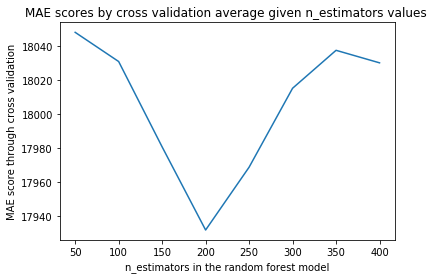

In [19]:
import matplotlib.pyplot as plt 
%matplotlib inline 

fig = plt.figure()
ax = plt.axes()

plt.plot(list(results.keys()), list(results.values()))
plt.title('MAE scores by cross validation average given n_estimators values ')
plt.xlabel('n_estimators in the random forest model')
plt.ylabel('MAE score through cross validation')